### Chest X‑ray Multi‑Pathology:

##### **Project goal:** build an unbiased AI diagnostic system for three thoracic pathologies (Atelectasis, Cardiomegaly, Effusion) and ensure consistent performance across demographic groups (age, gender) and imaging protocols (AP/PA).

##### **File structure expected (root):**
##### this notebook
##### `data/` folder containing: `train_split_full.csv`, `val_split_full.csv`, `test_split_full.csv`, `sample_labels.csv`
##### `data/images/` folder containing image files referenced by `Image Index`



### 1- Setup & Installation
##### Run these in your environment if packages aren't installed. In a shared environment, you can uncomment the pip lines.

In [59]:
# !pip install pandas matplotlib seaborn numpy scikit-learn torchvision pillow

### 2- Imports

In [60]:
import os
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### 3- Load CSVs and quick verification

In [61]:
# Paths (adjust if necessary)
ROOT = Path('.')
DATA_DIR = ROOT / 'data'
TRAIN_CSV = DATA_DIR / 'train_split_full.csv'
VAL_CSV = DATA_DIR / 'val_split_full.csv'
TEST_CSV = DATA_DIR / 'test_split_full.csv'
SAMPLE_LABELS = DATA_DIR / 'sample_labels.csv'

for p in [TRAIN_CSV, VAL_CSV, TEST_CSV, SAMPLE_LABELS]:
    print(p, 'exists->', p.exists())

data\train_split_full.csv exists-> True
data\val_split_full.csv exists-> True
data\test_split_full.csv exists-> True
data\sample_labels.csv exists-> True


In [62]:
# Load
train_df = pd.read_csv(TRAIN_CSV)
val_df = pd.read_csv(VAL_CSV)
test_df = pd.read_csv(TEST_CSV)
labels_df = pd.read_csv(SAMPLE_LABELS)

print(f"Train: {train_df.shape}, Val: {val_df.shape}, Test: {test_df.shape}, Labels: {labels_df.shape}")

# Show sample rows
train_df.head(6)

Train: (3884, 16), Val: (578, 16), Test: (1144, 16), Labels: (5606, 11)


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y,Age_Numeric,Age_Group,Atelectasis,Cardiomegaly,Effusion
0,00000017_001.png,No Finding,1,17,077Y,M,AP,2500,2048,0.168,0.168,77.0,>65,0,0,0
1,00000030_001.png,Atelectasis,1,30,079Y,M,PA,2992,2991,0.143,0.143,79.0,>65,1,0,0
2,00000032_001.png,Cardiomegaly|Edema|Effusion,1,32,055Y,F,AP,2500,2048,0.168,0.168,55.0,40-65,0,1,1
3,00000040_003.png,Consolidation|Mass,3,40,068Y,M,PA,2500,2048,0.168,0.168,68.0,>65,0,0,0
4,00000042_002.png,No Finding,2,42,071Y,M,AP,3056,2544,0.139,0.139,71.0,>65,0,0,0
5,00000061_002.png,Effusion,2,61,077Y,M,PA,2992,2991,0.143,0.143,77.0,>65,0,0,1


#### Verify no patient overlap between splits (patient-wise split)

In [63]:
train_patients = set(train_df['Patient ID'].astype(str).unique())
val_patients = set(val_df['Patient ID'].astype(str).unique())
test_patients = set(test_df['Patient ID'].astype(str).unique())


print(f"Unique patients - train: {len(train_patients)}, val: {len(val_patients)}, test: {len(test_patients)}")


overlap_train_val = train_patients & val_patients
overlap_train_test = train_patients & test_patients
overlap_val_test = val_patients & test_patients


print('Overlaps (should be empty):')
print('train ∩ val:', len(overlap_train_val))
print('train ∩ test:', len(overlap_train_test))
print('val ∩ test:', len(overlap_val_test))


# Assert none overlap (fail loudly if overlap exists)
assert len(overlap_train_val)==0, 'Patient overlap between train and val!'
assert len(overlap_train_test)==0, 'Patient overlap between train and test!'
assert len(overlap_val_test)==0, 'Patient overlap between val and test!'

Unique patients - train: 2961, val: 423, test: 846
Overlaps (should be empty):
train ∩ val: 0
train ∩ test: 0
val ∩ test: 0


#### Basic dataset statistics & pathology prevalence

In [64]:
def dataset_summary(df, name):
    n_images = len(df)
    n_patients = df['Patient ID'].nunique()
    gender_counts = df['Patient Gender'].value_counts(dropna=False).to_dict()
    view_counts = df['View Position'].value_counts(dropna=False).to_dict()
    mean_age = df['Age_Numeric'].mean()
    path_counts = {
        'Atelectasis': int(df['Atelectasis'].sum()),
        'Cardiomegaly': int(df['Cardiomegaly'].sum()),
        'Effusion': int(df['Effusion'].sum())
    }
    return {
        'split': name,
        'n_images': n_images,
        'n_patients': n_patients,
        'gender_counts': gender_counts,
        'view_counts': view_counts,
        'mean_age': mean_age,
        'path_counts': path_counts
    }


summary = [dataset_summary(train_df,'train'), dataset_summary(val_df,'val'), dataset_summary(test_df,'test')]
pd.DataFrame(summary)

,split,n_images,n_patients,gender_counts,view_counts,mean_age,path_counts
0,train,3884,2961,"{'M': 2163, 'F': 1721}","{'PA': 2346, 'AP': 1538}",46.956510,"{'Atelectasis': 368, 'Cardiomegaly': 95, 'Effu..."
1,val,578,423,"{'M': 326, 'F': 252}","{'PA': 358, 'AP': 220}",45.901389,"{'Atelectasis': 55, 'Cardiomegaly': 11, 'Effus..."
2,test,1144,846,"{'M': 645, 'F': 499}","{'PA': 689, 'AP': 455}",46.564685,"{'Atelectasis': 85, 'Cardiomegaly': 35, 'Effus..."


#### Global pathology prevalence (combined)

In [65]:
combined = pd.concat([train_df.assign(split='train'), val_df.assign(split='val'), test_df.assign(split='test')], ignore_index=True)
pathology_cols = ['Atelectasis','Cardiomegaly','Effusion']


for col in pathology_cols:
    total = combined[col].sum()
    pct = total/len(combined)
    print(f"{col}: {int(total)} positive images, {pct:.3%} prevalence")


# Multi-label distribution (counts of images with 0,1,2,3 positives)
combined['label_sum'] = combined[pathology_cols].sum(axis=1)
print('\nLabel cardinality:')
print(combined['label_sum'].value_counts().sort_index())

Atelectasis: 508 positive images, 9.062% prevalence
Cardiomegaly: 141 positive images, 2.515% prevalence
Effusion: 644 positive images, 11.488% prevalence

Label cardinality:
label_sum
0    4527
1     874
2     196
3       9
Name: count, dtype: int64


In [66]:
# Check for missing values:

missing_count = combined.isnull().sum().sort_values(ascending=False)
missing_count



Age_Group                      1
Image Index                    0
Finding Labels                 0
Follow-up #                    0
Patient Age                    0
Patient ID                     0
View Position                  0
OriginalImageWidth             0
OriginalImageHeight            0
Patient Gender                 0
OriginalImagePixelSpacing_x    0
OriginalImagePixelSpacing_y    0
Age_Numeric                    0
Atelectasis                    0
Cardiomegaly                   0
Effusion                       0
split                          0
label_sum                      0
dtype: int64

In [67]:
combined['Age_Group'].unique()

array(['>65', '40-65', '<40', nan], dtype=object)

In [68]:
# Define a function to categorize age
def age_to_group(age):
    if age > 65:
        return '>65'
    elif age >= 40:
        return '40-65'
    else:
        return '<40'

# Fill missing Age_Group
missing_mask = combined['Age_Group'].isnull()
combined.loc[missing_mask, 'Age_Group'] = combined.loc[missing_mask, 'Age_Numeric'].apply(age_to_group)

# Verify
print(combined['Age_Group'].isnull().sum())  # Should be 0 now
combined['Age_Group'].value_counts()

0


Age_Group
40-65    3021
<40      1908
>65       677
Name: count, dtype: int64

#### Where are the biggest class imbalances?
##### We'll produce tables and charts to answer:
##### Absolute counts & prevalence per split
##### Prevalence by Age_Group, Gender, and View Position

In [69]:
# Prevalence per split
split_summary = combined.groupby('split')[pathology_cols].agg(['sum','count'])
# Clean and show prevalence
for col in pathology_cols:
    print('\n--', col)
    for split in ['train','val','test']:
        df_split = combined[combined['split']==split]
        cnt = int(df_split[col].sum())
        pct = cnt / len(df_split)
        print(f"{split}: {cnt} ({pct:.3%})")


-- Atelectasis
train: 368 (9.475%)
val: 55 (9.516%)
test: 85 (7.430%)

-- Cardiomegaly
train: 95 (2.446%)
val: 11 (1.903%)
test: 35 (3.059%)

-- Effusion
train: 451 (11.612%)
val: 64 (11.073%)
test: 129 (11.276%)


### Demographic representation and pathology rates

In [70]:
def prevalence_by(df, group_col):
    # compute prevalence
    prevalence = {}
    for g in df[group_col].fillna('Unknown').unique():
        sub = df[df[group_col].fillna('Unknown')==g]
        n = len(sub)
        row = {col: (int(sub[col].sum()), sub[col].sum()/n if n>0 else np.nan) for col in pathology_cols}
        prevalence[g] = {'n': n, **row}
    return pd.DataFrame.from_dict(prevalence, orient='index')


# By Age_Group
age_prev = prevalence_by(combined, 'Age_Group')
age_prev_sorted = age_prev.sort_index()

# By Gender
gender_prev = prevalence_by(combined, 'Patient Gender')

# By View Position
view_prev = prevalence_by(combined, 'View Position')

# Display concise tables
print(age_prev_sorted)
print('\nPrevalence by Age_Group (top rows)')
print(age_prev_sorted.head(10))

print('\nPrevalence by Gender')
print(gender_prev)

print('\nPrevalence by View Position')
print(view_prev)

          n                 Atelectasis                Cardiomegaly  \
40-65  3021  (324, 0.10724925521350546)  (71, 0.023502151605428664)   
<40    1908  (112, 0.05870020964360587)   (50, 0.02620545073375262)   
>65     677   (72, 0.10635155096011817)  (20, 0.029542097488921712)   

                         Effusion  
40-65  (365, 0.12082092022509103)  
<40    (173, 0.09067085953878407)  
>65    (106, 0.15657311669128507)  

Prevalence by Age_Group (top rows)
          n                 Atelectasis                Cardiomegaly  \
40-65  3021  (324, 0.10724925521350546)  (71, 0.023502151605428664)   
<40    1908  (112, 0.05870020964360587)   (50, 0.02620545073375262)   
>65     677   (72, 0.10635155096011817)  (20, 0.029542097488921712)   

                         Effusion  
40-65  (365, 0.12082092022509103)  
<40    (173, 0.09067085953878407)  
>65    (106, 0.15657311669128507)  

Prevalence by Gender
      n                 Atelectasis               Cardiomegaly  \
M  3134  (321, 0.1

#### Visualizations
##### We'll create the following plots:
##### - Pathology prevalence bar chart (overall)
##### - Prevalence by Age_Group (stacked or grouped bar)
##### - Prevalence by Gender
##### - Prevalence by View Position (AP vs PA)
##### - Heatmap of pathology co-occurrence

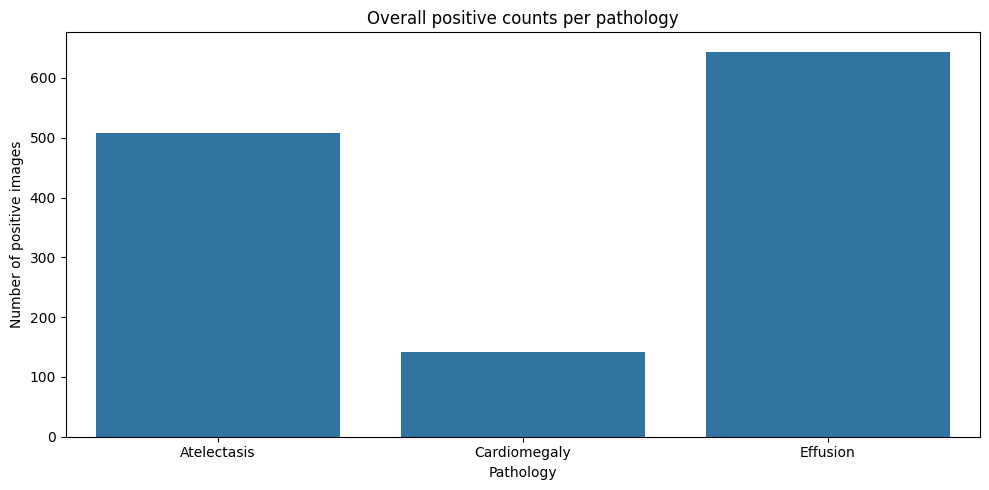

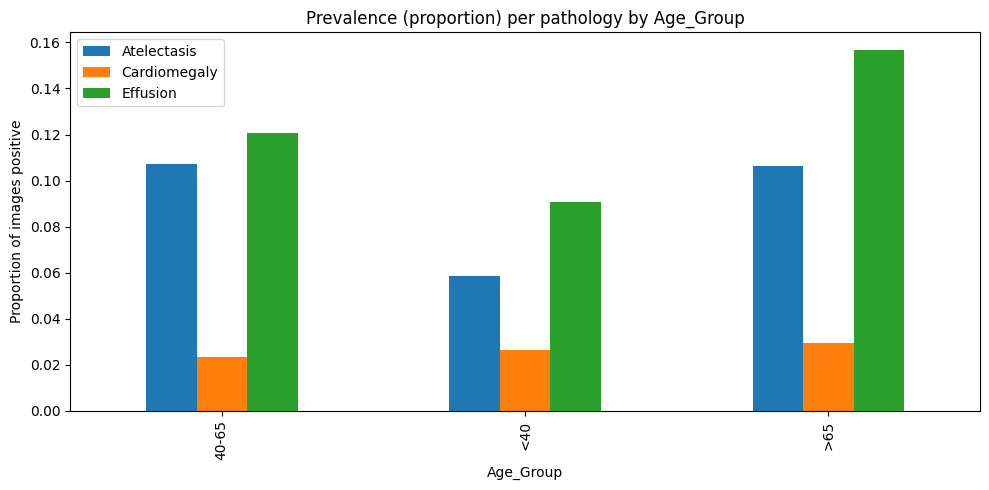

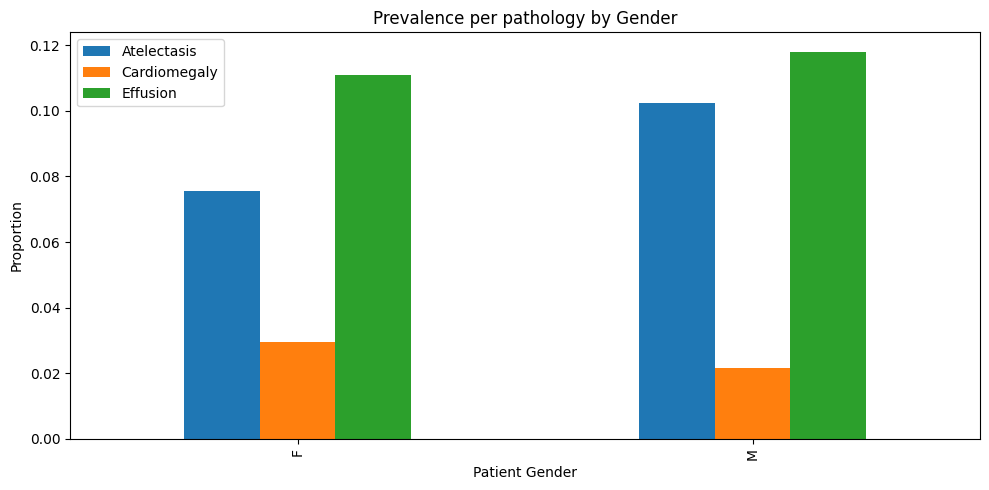

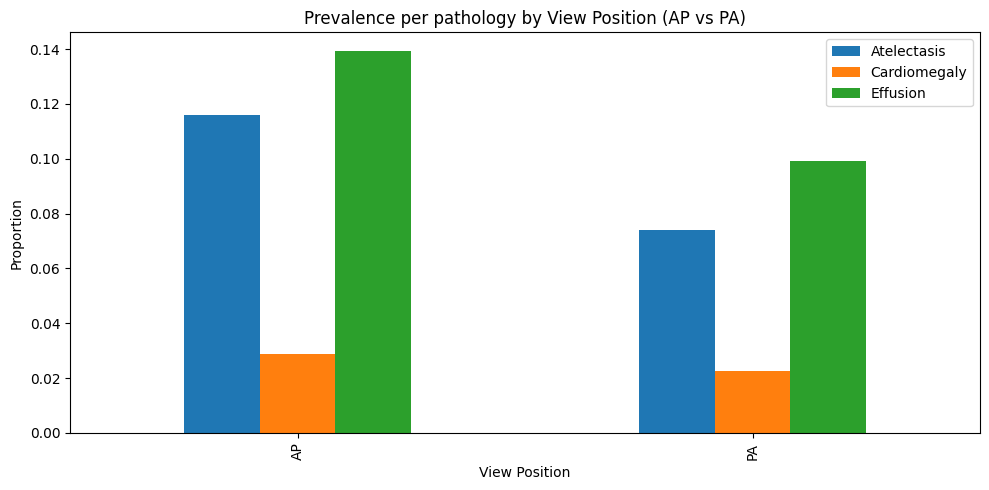

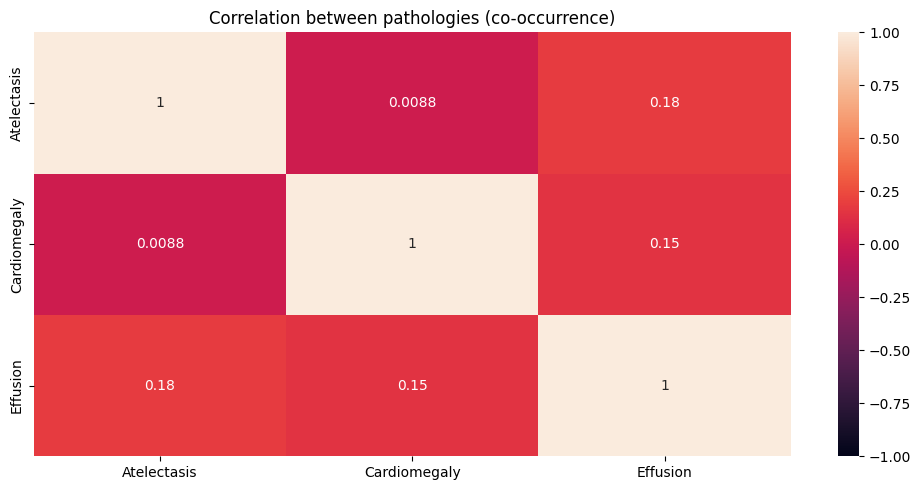

In [71]:
# Overall prevalence
plt.figure()
counts = [combined[col].sum() for col in pathology_cols]
sns.barplot(x=pathology_cols, y=counts)
plt.title('Overall positive counts per pathology')
plt.ylabel('Number of positive images')
plt.xlabel('Pathology')
plt.tight_layout()
plt.show()


# Prevalence by Age_Group
age_groups = combined['Age_Group'].fillna('Unknown').unique()
age_groups = sorted(age_groups, key=lambda x: (str(x)))
age_group_df = combined.groupby('Age_Group')[pathology_cols].mean().loc[age_groups]
age_group_df.plot(kind='bar')
plt.title('Prevalence (proportion) per pathology by Age_Group')
plt.ylabel('Proportion of images positive')
plt.tight_layout()
plt.show()


# Prevalence by Gender
gender_df = combined.groupby('Patient Gender')[pathology_cols].mean()
gender_df.plot(kind='bar')
plt.title('Prevalence per pathology by Gender')
plt.ylabel('Proportion')
plt.tight_layout()
plt.show()


# Prevalence by View Position
view_df = combined.groupby('View Position')[pathology_cols].mean()
view_df.plot(kind='bar')
plt.title('Prevalence per pathology by View Position (AP vs PA)')
plt.ylabel('Proportion')
plt.tight_layout()
plt.show()


# Co-occurrence heatmap
cooc = combined[pathology_cols].corr()
sns.heatmap(cooc, annot=True, vmin=-1, vmax=1)
plt.title('Correlation between pathologies (co-occurrence)')
plt.tight_layout()
plt.show()

### 2. Data Preprocessing for Chest X-Ray Multi-Pathology Classification

#### A. Data Validation

##### Check for corrupted images

In [72]:
from PIL import Image
import os

def check_images(image_dir, image_list):
    corrupted = []
    for img_name in image_list:
        img_path = os.path.join(image_dir, img_name)
        try:
            with Image.open(img_path) as im:
                im.verify()  # check for corruption
        except Exception as e:
            corrupted.append(img_name)
    return corrupted

corrupted_train = check_images('data/images', combined['Image Index'])
print(f"Corrupted images: {corrupted_train}")

Corrupted images: []


In [73]:
# Confirm pathology columns are numeric and no missing values
print(combined[pathology_cols].isnull().sum())

print(combined['OriginalImageWidth'].describe())
print(combined['OriginalImageHeight'].describe())
print(combined['View Position'].value_counts())

Atelectasis     0
Cardiomegaly    0
Effusion        0
dtype: int64
count    5606.000000
mean     2644.795755
std       347.188754
min      1362.000000
25%      2500.000000
50%      2542.000000
75%      2992.000000
max      3266.000000
Name: OriginalImageWidth, dtype: float64
count    5606.000000
mean     2491.087406
std       399.119063
min       966.000000
25%      2048.000000
50%      2544.000000
75%      2991.000000
max      3056.000000
Name: OriginalImageHeight, dtype: float64
View Position
PA    3393
AP    2213
Name: count, dtype: int64


#### B. Medical Imaging Preprocessing

1. Standardize dimensions
2. Normalize pixel values
3. Data Imbalance Handling
4. Pipeline Development

In [79]:
import os
import torch
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from PIL import Image
from torchvision import transforms
from math import ceil

# --- 1. Define image directory and pathology columns ---
image_dir = 'data/images'
pathology_cols = ['Atelectasis', 'Cardiomegaly', 'Effusion']

# --- 2. Standard and augmentation transforms ---
standard_transform = transforms.Compose([
    transforms.Resize((1024, 1024)),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

augment_transform = transforms.Compose([
    transforms.Resize((1024, 1024)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

# --- 3. Define Dataset ---
class ChestXRayDataset(Dataset):
    def __init__(self, df, pathology_cols, transform=standard_transform, augment_transform=augment_transform, augment_threshold=0.1):
        self.df = df.reset_index(drop=True)
        self.pathology_cols = pathology_cols
        self.transform = transform
        self.augment_transform = augment_transform
        self.augment_threshold = augment_threshold
        self.total_samples = len(df)
        
        # Ensure labels are numeric
        for col in pathology_cols:
            self.df[col] = pd.to_numeric(self.df[col], errors='coerce').fillna(0).astype(float)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        
        # Labels
        labels_array = row[self.pathology_cols].to_numpy(dtype=float)
        labels = torch.tensor(labels_array, dtype=torch.float32)
        
        # Determine if minority class (for on-the-fly augmentation)
        is_minority = any((row[col]==1) and (self.df[col].sum()/self.total_samples < self.augment_threshold)
                          for col in self.pathology_cols)
        
        transform = self.augment_transform if is_minority else self.transform
        
        # Load and transform image
        img_path = os.path.join(image_dir, row['Image Index'])
        img = Image.open(img_path).convert('L')
        img_tensor = transform(img)
        
        return img_tensor, labels

# --- 4. Weighted random sampler for oversampling minority classes ---
def create_sampler(df, pathology_cols, threshold=0.1):
    """
    Create a WeightedRandomSampler to oversample minority classes.
    """
    # Compute sample weights
    weights = []
    total_samples = len(df)
    for idx, row in df.iterrows():
        sample_weight = 1.0
        for col in pathology_cols:
            prevalence = df[col].sum() / total_samples
            if row[col] == 1 and prevalence < threshold:
                # Increase weight for minority
                sample_weight *= ceil(threshold / max(prevalence, 1e-6))
        weights.append(sample_weight)
    
    sampler = WeightedRandomSampler(weights, num_samples=len(weights), replacement=True)
    return sampler

# --- 5. Example usage ---
# Create Dataset
# Assuming your original DataFrame is called `combined`
train_dataset = ChestXRayDataset(combined, pathology_cols, augment_threshold=0.1)

# Create sampler for minority oversampling
sampler = create_sampler(combined, pathology_cols, threshold=0.1)

# DataLoader
train_loader = DataLoader(train_dataset, batch_size=16, sampler=sampler)

# Example batch
for images, labels in train_loader:
    print(images.shape, labels.shape)
    break


torch.Size([16, 1, 1024, 1024]) torch.Size([16, 3])
